# Assignment Task 2 - Plotting Gradient for each layer

### SAHIL AMRITKAR
### 20BRS1180  


In [4]:
import tensorflow as tf
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras import Sequential
from tensorflow.keras.initializers import RandomNormal
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
import numpy as np

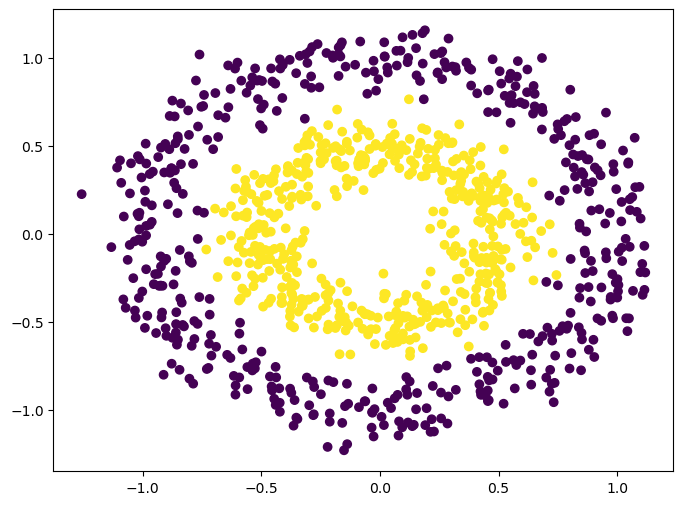

In [5]:
tf.random.set_seed(42)
np.random.seed(42)
 
# Make data: Two circles on x-y plane as a classification problem
X, y = make_circles(n_samples=1000, factor=0.5, noise=0.1)
plt.figure(figsize=(8,6))
plt.scatter(X[:,0], X[:,1], c=y)
plt.show()

In [9]:
# Illustrate weights across epochs
class WeightCapture(Callback):
    "Capture the weights of each layer of the model"
    def __init__(self, model):
        super().__init__()
        self.model = model
        self.weights = []
        self.epochs = []
 
    def on_epoch_end(self, epoch, logs=None):
        self.epochs.append(epoch) # remember the epoch axis
        weight = {}
        for layer in model.layers:
            if not layer.weights:
                continue
            name = layer.weights[0].name.split("/")[0]
            weight[name] = layer.weights[0].numpy()
        self.weights.append(weight)
 
def make_mlp(activation, initializer, name):
    "Create a model with specified activation and initalizer"
    model = Sequential([
        Input(shape=(2,), name=name+"0"),
        Dense(5, activation=activation, kernel_initializer=initializer, name=name+"1"),
        Dense(5, activation=activation, kernel_initializer=initializer, name=name+"2"),
        Dense(5, activation=activation, kernel_initializer=initializer, name=name+"3"),
        Dense(5, activation=activation, kernel_initializer=initializer, name=name+"4"),
        Dense(1, activation="sigmoid", kernel_initializer=initializer, name=name+"5")
    ])
    return model
 
def plotweight(capture_cb):
    "Plot the weights' mean and s.d. across epochs"
    fig, ax = plt.subplots(2, 1, sharex=True, constrained_layout=True, figsize=(8, 10))
    ax[0].set_title("Mean weight")
    for key in capture_cb.weights[0]:
        ax[0].plot(capture_cb.epochs, [w[key].mean() for w in capture_cb.weights], label=key)
    ax[0].legend()
    ax[1].set_title("S.D.")
    for key in capture_cb.weights[0]:
        ax[1].plot(capture_cb.epochs, [w[key].std() for w in capture_cb.weights], label=key)
    ax[1].legend()
    plt.show()

In [10]:

initializer = RandomNormal(mean=0, stddev=1)
batch_size = 32
n_epochs = 100

In [14]:
# Show gradient across epochs
optimizer = tf.keras.optimizers.RMSprop()
loss_fn = tf.keras.losses.BinaryCrossentropy()
 
def train_model(X, y, model, n_epochs=n_epochs, batch_size=batch_size):
    "Run training loop manually"
    train_dataset = tf.data.Dataset.from_tensor_slices((X, y))
    train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)
 
    gradhistory = []
    losshistory = []
    def recordweight():
        data = {}
        for g,w in zip(grads, model.trainable_weights):
            if '/kernel:' not in w.name:
                continue # skip bias
            name = w.name.split("/")[0]
            data[name] = g.numpy()
        gradhistory.append(data)
        losshistory.append(loss_value.numpy())
    for epoch in range(n_epochs):
        for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
            with tf.GradientTape() as tape:
                y_pred = model(x_batch_train, training=True)
                loss_value = loss_fn(y_batch_train, y_pred)
 
            grads = tape.gradient(loss_value, model.trainable_weights)
            optimizer.apply_gradients(zip(grads, model.trainable_weights))
 
            if step == 0:
                recordweight()
    # After all epochs, record again
    recordweight()
    return gradhistory, losshistory
 
def plot_gradient(gradhistory, losshistory):
    "Plot gradient mean and sd across epochs"
    fig, ax = plt.subplots(3, 1, sharex=True, constrained_layout=True, figsize=(8, 12))
    ax[0].set_title("Mean gradient")
    for key in gradhistory[0]:
        ax[0].plot(range(len(gradhistory)), [w[key].mean() for w in gradhistory], label=key)
    ax[0].legend()
    ax[1].set_title("S.D.")
    for key in gradhistory[0]:
        ax[1].semilogy(range(len(gradhistory)), [w[key].std() for w in gradhistory], label=key)
    ax[1].legend()
    ax[2].set_title("Loss")
    ax[2].plot(range(len(losshistory)), losshistory)
    plt.show()

Before training: Accuracy 0.5
After training: Accuracy 0.652


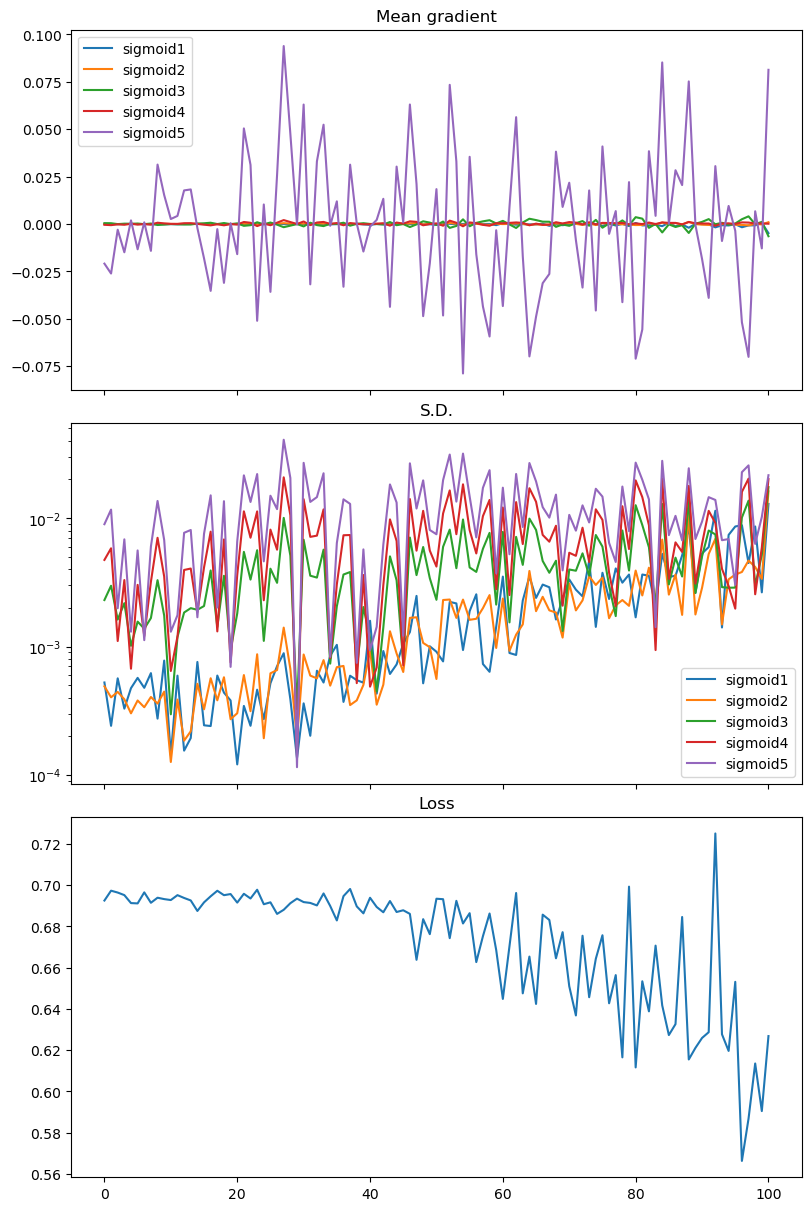

In [15]:
model = make_mlp("sigmoid", initializer, "sigmoid")
print("Before training: Accuracy", accuracy_score(y, (model(X) > 0.5)))
gradhistory, losshistory = train_model(X, y, model)
print("After training: Accuracy", accuracy_score(y, (model(X) > 0.5)))
plot_gradient(gradhistory, losshistory)

Before training: Accuracy 0.503
After training: Accuracy 0.995


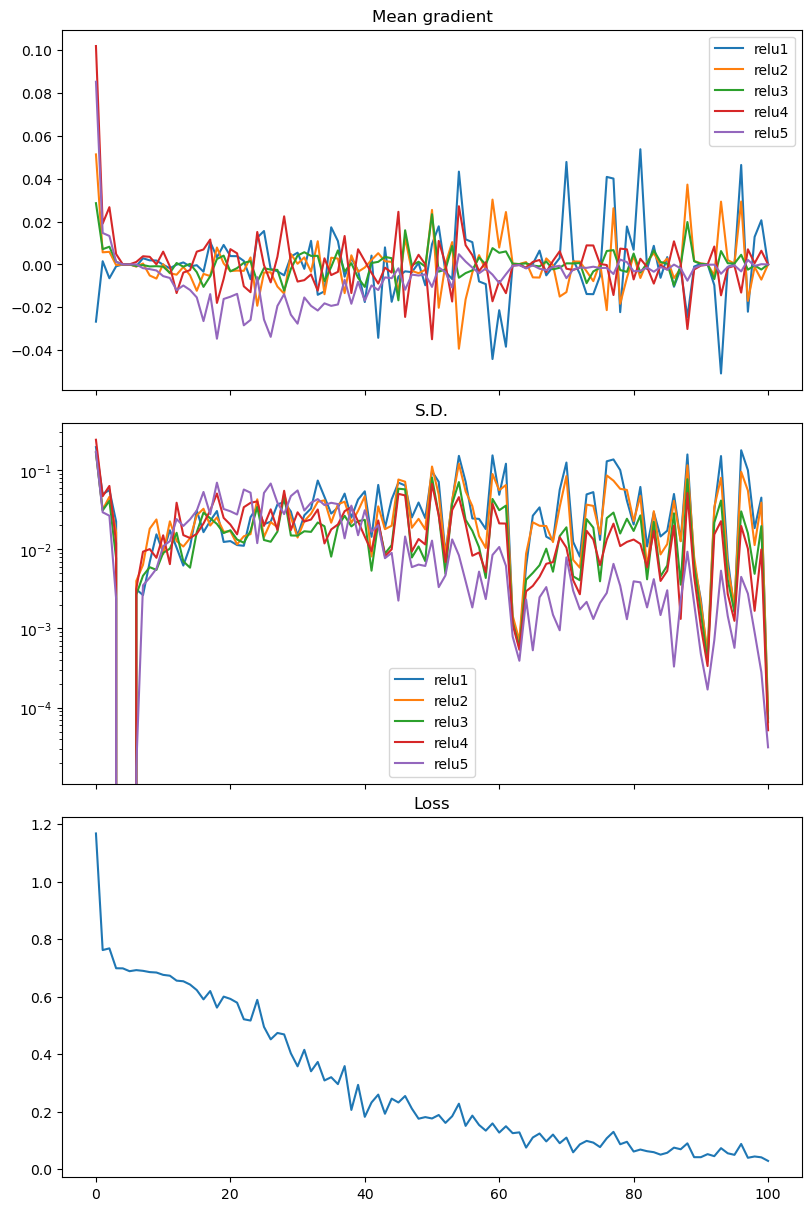

In [17]:
model = make_mlp("relu", initializer, "relu")
print("Before training: Accuracy", accuracy_score(y, (model(X) > 0.5)))
gradhistory, losshistory = train_model(X, y, model)
print("After training: Accuracy", accuracy_score(y, (model(X) > 0.5)))
plot_gradient(gradhistory, losshistory)